In [8]:
%matplotlib inline
import ipywidgets as widgets
from ipywidgets import interact
import numpy as np
import matplotlib.pyplot as pl
from scipy.spatial.distance import cdist
from numpy.linalg import inv
import george

Following Suzanne Aigrain's LSST tutorial on GPs: https://github.com/LSSTC-DSFP/LSSTC-DSFP-Sessions/blob/master/Session4/Day2/GPLecture1.ipynb

In [9]:
def SEKernel(par, x1, x2):
    A, Gamma = par
    D2 = cdist(x1.reshape(len(x1),1), x2.reshape(len(x2),1), 
               metric = 'sqeuclidean')
    return A * np.exp(-Gamma*D2)

def Pred_GP(CovFunc, CovPar, xobs, yobs, eobs, xtest):
    # evaluate the covariance matrix for pairs of observed inputs
    K = CovFunc(CovPar, xobs, xobs) 
    # add white noise
    K += np.identity(xobs.shape[0]) * eobs**2
    # evaluate the covariance matrix for pairs of test inputs
    Kss = CovFunc(CovPar, xtest, xtest)
    # evaluate the cross-term
    Ks = CovFunc(CovPar, xtest, xobs)
    # invert K
    Ki = inv(K)
    # evaluate the predictive mean
    m = np.dot(Ks, np.dot(Ki, yobs))
    # evaluate the covariance
    cov = Kss - np.dot(Ks, np.dot(Ki, Ks.T))
    return m, cov

In [10]:
import pandas as pd

ts = pd.read_csv('/Users/chris/Desktop/superflares/c12/246300000/01900/ts.txt', sep=", ", header=0)
ts.columns = ["BJD - 2454833", "Corrected Flux"] 
print(ts.head())
print(ts.tail())

   BJD - 2454833  Corrected Flux
0    2905.581553        0.984912
1    2905.601985        0.985306
2    2905.622418        0.985967
3    2905.642850        0.985878
4    2905.663282        0.986161
      BJD - 2454833  Corrected Flux
3348    2984.161921        1.039136
3349    2984.182353        1.038834
3350    2984.202784        1.044875
3351    2984.223216        1.042245
3352    2984.243648        1.041783


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:3: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  This is separate from the ipykernel package so we can avoid doing imports until


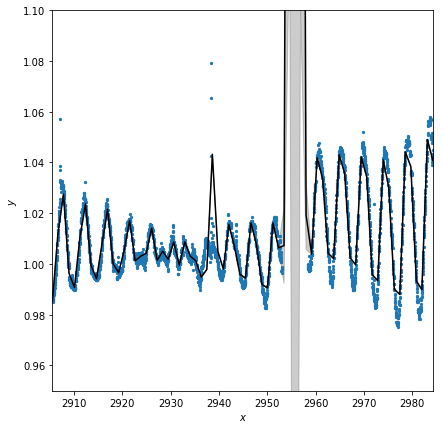

In [12]:
#xobs = np.array([-1,1,2])
#yobs = np.array([1,-1,0])
xobs = np.array(ts["BJD - 2454833"])
yobs = np.array(ts["Corrected Flux"])
eobs = 0.001*np.ones(len(ts)) # PLACEHOLDER...NOT SURE WHERE TO FIND ERRORS OR IF THERE EVEN ARE ANY??
pl.figure(figsize=(15,7))
A = 1
Gamma = 0.5
"""
x = np.array([-2.5,-2,-1.5,-0.5, 0.0, 0.5,1.5,2.5])
m,C=Pred_GP(SEKernel,[A,Gamma],xobs,yobs,eobs,x)
sig = np.sqrt(np.diag(C))
for i in range(len(x)):
    pl.plot([x[i]-0.1,x[i]+0.1],[m[i],m[i]],'k-')
    pl.fill_between([x[i]-0.1,x[i]+0.1],
                    [m[i]+sig[i],m[i]+sig[i]],
                    [m[i]-sig[i],m[i]-sig[i]],color='k',alpha=0.2)
pl.xlim(-3,3)
pl.ylim(-3,3)
pl.xlabel(r'$x$')
pl.ylabel(r'$y$');
"""
pl.subplot(121)
#pl.errorbar(xobs,yobs,eobs,capsize=0,fmt='k.')
x = np.linspace(2905.56,2984.26,70)
m,C=Pred_GP(SEKernel,[A,Gamma],xobs,yobs,eobs,x)
sig = np.sqrt(np.diag(C))
pl.plot(x,m,'k-')
pl.fill_between(x,m+sig,m-sig,color='k',alpha=0.2)
pl.xlim(2905.56,2984.26)
pl.ylim(0.95,1.1)
pl.xlabel(r'$x$')
pl.ylabel(r'$y$')
pl.scatter(ts['BJD - 2454833'], ts['Corrected Flux'],s=5);

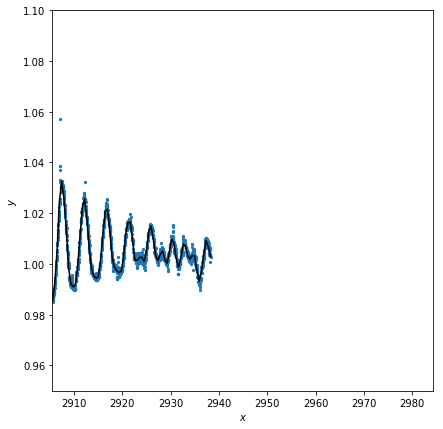

In [13]:
pre = ts.loc[:1512]
xobs = np.array(pre["BJD - 2454833"])
yobs = np.array(pre["Corrected Flux"])
eobs = 0.001*np.ones(len(pre)) # PLACEHOLDER...NOT SURE WHERE TO FIND ERRORS OR IF THERE EVEN ARE ANY??
pl.figure(figsize=(15,7))
A = 1
Gamma = 0.5

pl.subplot(121)
x = np.linspace(2905.56,2984.26,70)
x = np.linspace(pre['BJD - 2454833'][0], pre['BJD - 2454833'][len(pre)-1], 70)
m,C=Pred_GP(SEKernel,[A,Gamma],xobs,yobs,eobs,x)
sig = np.sqrt(np.diag(C))

pl.plot(x,m,'k-')
pl.fill_between(x,m+sig,m-sig,color='k',alpha=0.2)
pl.xlim(2905.56,2984.26)
pl.ylim(0.95,1.1)
pl.xlabel(r'$x$')
pl.ylabel(r'$y$')
pl.scatter(pre['BJD - 2454833'], pre['Corrected Flux'],s=5);

Considered trying with Quasi-Periodic kernel, a la Angus et al. (2017), but that requires at least a guess at the rotational period...and isn't that counter-productive because we're trying to look at a variable period?

So, instead, here's what happens when I subtract out the inference from the data.

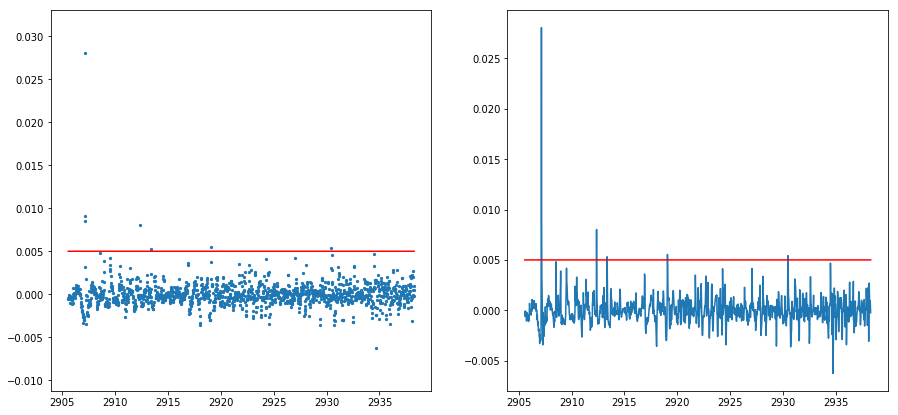

In [15]:
xobs = np.array(pre["BJD - 2454833"])
yobs = np.array(pre["Corrected Flux"])
eobs = 0.001*np.ones(len(pre)) # PLACEHOLDER...NOT SURE WHERE TO FIND ERRORS OR IF THERE EVEN ARE ANY??
pl.figure(figsize=(15,7))
A = 1
Gamma = 0.5
threshold = 0.005

pl.subplot(121)
#x = np.linspace(2905.56,2984.26,70)
x = np.linspace(pre['BJD - 2454833'][0], pre['BJD - 2454833'][len(pre)-1], 70)
m,C=Pred_GP(SEKernel,[A,Gamma],xobs,yobs,eobs,x)
sig = np.sqrt(np.diag(C))
##pl.plot(pre['BJD - 2454833'],pre['Corrected Flux']-1)

#interpolate so I can subtract model from data
from scipy.interpolate import CubicSpline
cs = CubicSpline(x, m)
###pl.plot(pre['BJD - 2454833'], cs(pre['BJD - 2454833'])-1)

pl.subplot(121)
pl.scatter(pre['BJD - 2454833'],pre['Corrected Flux']-cs(pre['BJD - 2454833']),s=5)
pl.plot(xobs,threshold*np.ones(len(xobs)),c='r')
pl.subplot(122)
pl.plot(pre['BJD - 2454833'],pre['Corrected Flux']-cs(pre['BJD - 2454833']))
pl.plot(xobs,threshold*np.ones(len(xobs)),c='r')

And the second half of the time series...

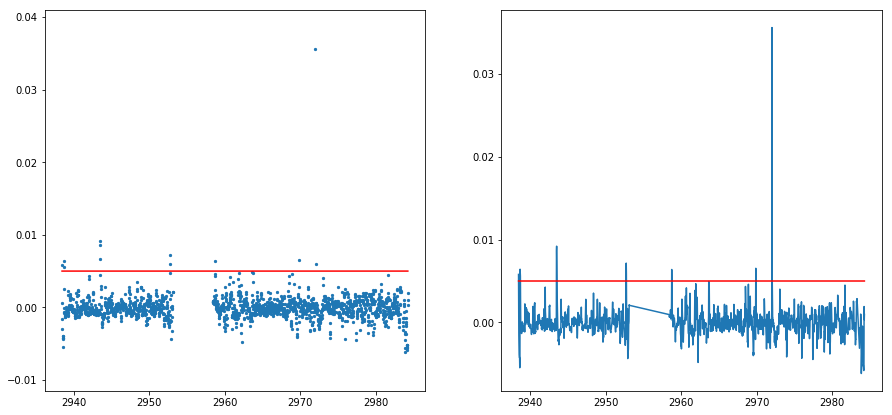

In [16]:
post = ts.iloc[1519:].reset_index()
xobs = np.array(post["BJD - 2454833"])
yobs = np.array(post["Corrected Flux"])
eobs = 0.001*np.ones(len(post)) # PLACEHOLDER...NOT SURE WHERE TO FIND ERRORS OR IF THERE EVEN ARE ANY??
pl.figure(figsize=(15,7))
A = 1
Gamma = 0.5

# inference on post-super flare time series
pl.subplot(121)
x = np.linspace(post['BJD - 2454833'][0], post['BJD - 2454833'][len(post)-1], 70)
m,C=Pred_GP(SEKernel,[A,Gamma],xobs,yobs,eobs,x) 
sig = np.sqrt(np.diag(C))
###pl.plot(post['BJD - 2454833'],post['Corrected Flux']-1)

#interpolate so I can subtract model from data
from scipy.interpolate import CubicSpline
cs = CubicSpline(x, m)
###pl.plot(post['BJD - 2454833'], cs(post['BJD - 2454833'])-1)

pl.subplot(121)
pl.scatter(post['BJD - 2454833'],post['Corrected Flux']-cs(post['BJD - 2454833']),s=5)
threshold = 0.005
pl.plot(xobs,threshold*np.ones(len(xobs)),c='r')
pl.subplot(122)
pl.plot(post['BJD - 2454833'],post['Corrected Flux']-cs(post['BJD - 2454833']))
pl.plot(xobs,threshold*np.ones(len(xobs)),c='r')
